<a href="https://colab.research.google.com/github/valdas-v1/Fatal-Police-Shooting-in-United-States/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fatal Police Shooting in United States

This project will take a look at killings that took place at the hands of police officers in the United States from the beginning of 2015 to into February 2017. The main goal is to explore the data, provide a list of issues and propose a plan on how to tackle these issues.

Details about the dataset can be found [here](https://www.kaggle.com/washingtonpost/police-shootings)

## Imports and dataset cleaning

### Imports

In [48]:
# Data wrangling
import pandas as pd
import numpy as np

# Statistics
import scipy.stats as st

# Visualisations
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt


# Custom display class that enables display of multiple objects in a single cell output
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/valdas-v1/Fatal-Police-Shooting-in-United-States/master/data.csv')
df.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       2142 non-null   int64  
 1   name                     2123 non-null   object 
 2   date                     2142 non-null   object 
 3   manner_of_death          2142 non-null   object 
 4   armed                    2136 non-null   object 
 5   age                      2099 non-null   float64
 6   gender                   2141 non-null   object 
 7   race                     2039 non-null   object 
 8   city                     2142 non-null   object 
 9   state                    2142 non-null   object 
 10  signs_of_mental_illness  2142 non-null   bool   
 11  threat_level             2142 non-null   object 
 12  flee                     2106 non-null   object 
 13  body_camera              2142 non-null   bool   
dtypes: bool(2), float64(1), 

Since there are null values, the dataset will need to be cleaned

### Cleaning dataset

In [9]:
# Counting null values in each column

df.isnull().sum()

id                           0
name                        19
date                         0
manner_of_death              0
armed                        6
age                         43
gender                       1
race                       103
city                         0
state                        0
signs_of_mental_illness      0
threat_level                 0
flee                        36
body_camera                  0
dtype: int64

In [10]:
# Dropping all null values

clean_df = df.dropna().drop('id', axis=1).reset_index()

clean_df

,index,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,0,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False
1,1,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False
2,2,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False
3,3,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False
4,4,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1981,2137,James Leroy Marker,2017-02-26,shot,gun,66.0,M,W,Floral City,FL,False,other,Car,False
1982,2138,Joey J. Bridges,2017-02-27,shot,gun,27.0,M,W,Shelby,NC,True,attack,Foot,False
1983,2139,Shawn M. Igers,2017-02-27,shot,gun,40.0,M,W,Corning,WI,False,attack,Not fleeing,False
1984,2140,Earl Riley,2017-02-28,shot,gun,25.0,M,B,Houston,TX,False,attack,Not fleeing,False


In [11]:
# Parsing date column

clean_df['date'] = pd.to_datetime(clean_df['date'])

## Mental ilness among fatal police shootings

### Preprocessing data

In [12]:
# Grouping the data by state and if there are signs of mental ilness

mi = clean_df.groupby(['state','signs_of_mental_illness'], as_index = False).index.count()
mi.sort_values(by = ['signs_of_mental_illness', 'index'], ascending=[False, False], inplace = True)
mi = mi.rename(columns={"index": "count"})

In [13]:
mi.head(3)

,state,signs_of_mental_illness,count
9,CA,True,76
84,TX,True,45
19,FL,True,34


### Fatal shootings by state

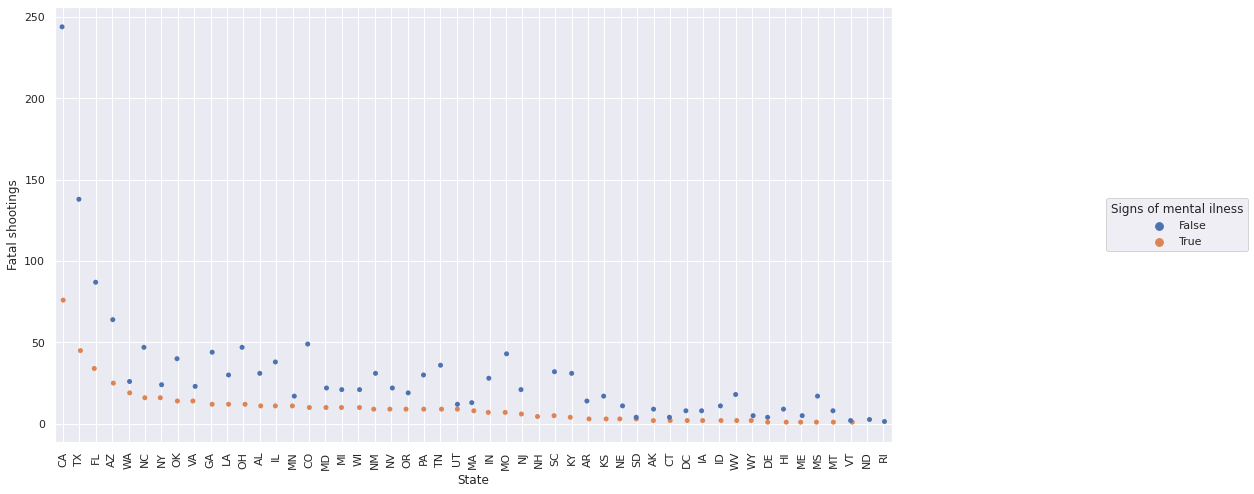

In [14]:
# Plotting the data

fig, ax = plt.subplots(figsize = (15,8))
sns.stripplot(ax = ax,data = mi, x = 'state', y = 'count',
              hue = 'signs_of_mental_illness').legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Signs of mental ilness')
plt.xticks(rotation=90)
ax.xaxis.grid(True)
plt.ylabel('Fatal shootings')
plt.xlabel('State')        
plt.show()       

We can see that California has by far the most fatal shootings by the police, let us see if their average rate of shooting a mentally ill person is higher than the national average

### Testing the hypothesis, that California's proportion of fatally shot people, with a mental illness is equal to the national proportion, with a 95% significance level: 

### H0: pC = pN

In [15]:
# Calculating the proportion for every state

rate_of_shot_mi = mi.pivot('state','signs_of_mental_illness','count').apply(lambda x: x/x.sum(), axis = 1).sort_values(by = True).dropna()
rate_of_shot_mi.head(3)

signs_of_mental_illness,False,True
state,,
MS,0.944444,0.055556
WV,0.900000,0.100000
HI,0.900000,0.100000


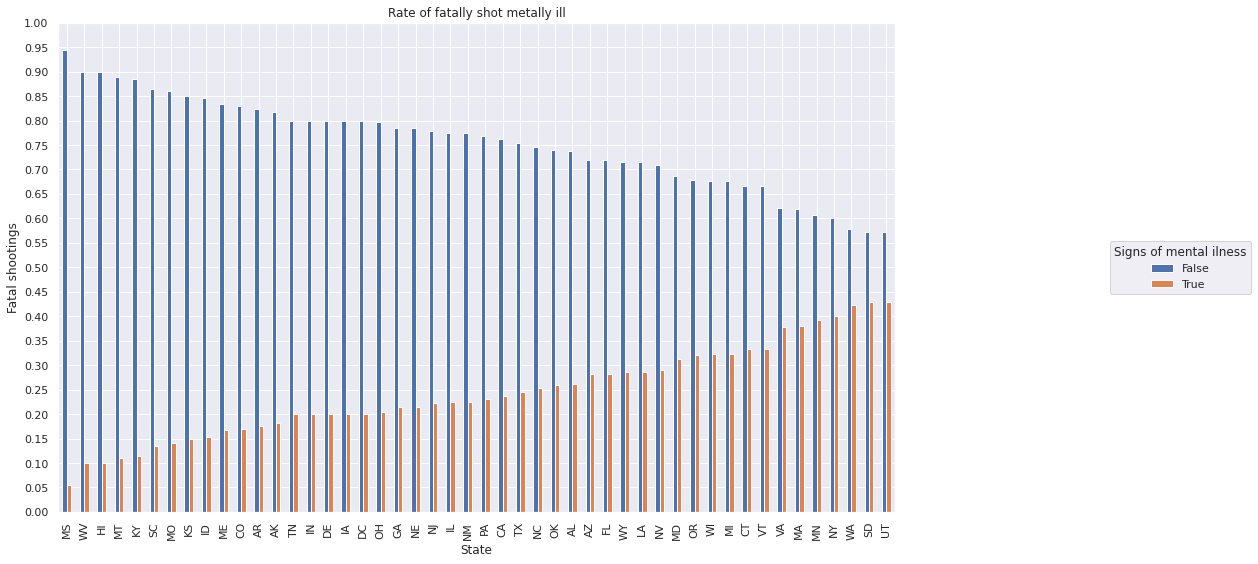

In [16]:
# Plotting the proportion for every state

fig, ax = plt.subplots(figsize = (15,9))
rate_of_shot_mi.plot(kind='bar', ax=ax).legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Signs of mental ilness')
plt.yticks(np.arange(0,1.05,0.05))
plt.ylabel('Fatal shootings')
plt.xlabel('State')
plt.title('Rate of fatally shot metally ill')
plt.show()  

Although California has a rate close to the middle, we can see that Utah has the highest rate, while Massachusetts has the lowest. Let us see if it is statistically significan using a z-test

### One-proportion z-test to test the null hypothesis

In [17]:
# Defining variables for a One-proportion z-test
p_hat = rate_of_shot_mi[True].loc['CA']
p_0 = np.mean(rate_of_shot_mi[True])
n = np.sum(mi[mi['state'] == 'CA']['count'])

p_hat, p_0, n

(0.2375, 0.24475642351104213, 320)

In [18]:
# Calculating One-proportion z-test
z = (p_hat*p_0) / np.sqrt(p_0*(1 - p_0)) * np.sqrt(n)
z

2.4185893282110684

In [47]:
# Calculating the p-value
p = 1 - st.norm.cdf(z)
p

0.0077904097297083474

We can reject the null hypothesis that the proportion of California and the national population proportion is equal (pC = pN), with a significance level of 95% as the p-value is 0.78%

## Racial bias among fatal police shootings

### Racial distribution of fatal police shootings

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


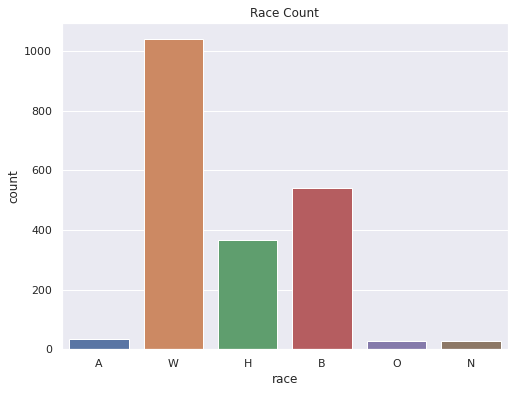

In [20]:
# Plotting the race among fatal police shootings

fig, ax = plt.subplots(figsize=(8,6))
sns.countplot(df['race'],ax=ax)
plt.title('Race Count')
plt.show()

Although it seems as if white people are shot most often, we need to keep in mind that >70% of the racial composition of the United States is white. Let us calculate the proportion of fatally shot unarmed people by race

### Percentage of unarmed people shot by race

In [21]:
# Grouping the data by race and if they were armed

df_armed = clean_df
df_armed['armed'] = clean_df['armed'] != 'unarmed'

race_armed = df_armed.groupby(['race','armed'], as_index = False).index.count()
race_armed.sort_values(by = ['armed', 'index'], ascending=[False, False], inplace = True)
race_armed = race_armed.rename(columns={"index": "count"})
race_armed

,race,armed,count
10,W,True,962
2,B,True,467
4,H,True,326
0,A,True,32
6,N,True,24
8,O,True,24
9,W,False,60
1,B,False,56
3,H,False,29
7,O,False,4


In [22]:
# Calculating the percentage of armed and unarmed police shootings

rate_race_armed = race_armed.pivot('race', 'armed', 'count').apply(lambda x: x/x.sum(), axis = 1).sort_values(by = True).dropna()
rate_race_armed

armed,False,True
race,,
O,0.142857,0.857143
B,0.107075,0.892925
H,0.081690,0.918310
N,0.076923,0.923077
W,0.058708,0.941292


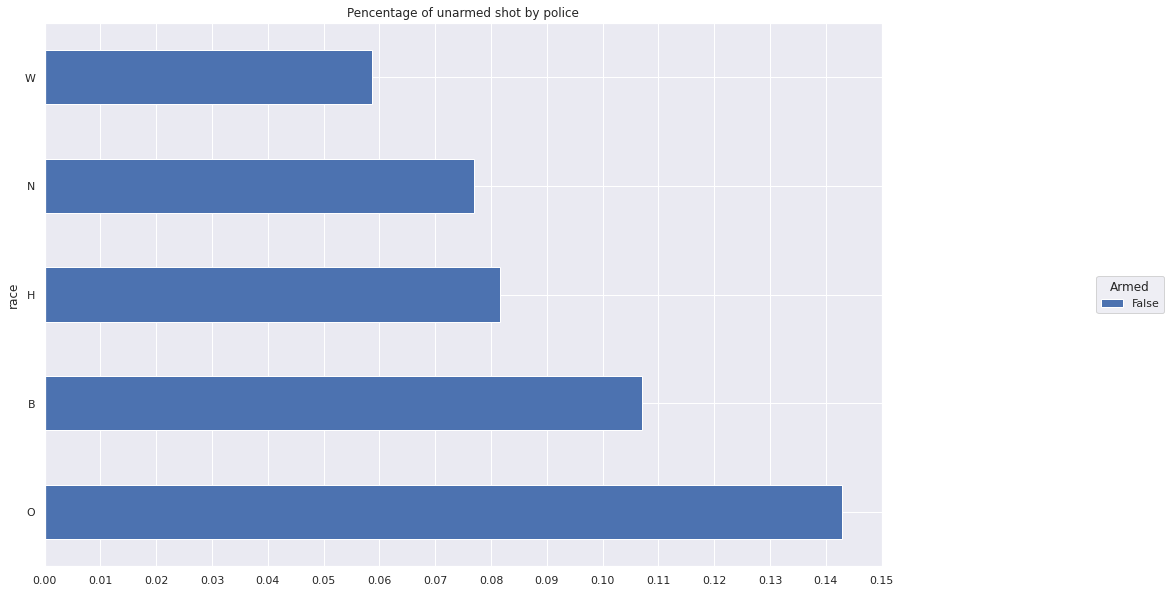

In [23]:
# Plotting the results

fig, ax = plt.subplots(figsize = (15,10))
rate_race_armed[False].plot(kind = 'barh', stacked = True,ax = ax).legend(loc='center left', 
                                                      bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

plt.xticks(np.arange(0,np.max(rate_race_armed[False])+0.01,0.01))
plt.title('Pencentage of unarmed shot by police')
plt.show()

We can see that only ~6% of white and ~11% of black people were unarmed when they were shot

## Dimensionality reduction

### Preprocessing data for PCA and t-SNE

In [24]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    1986 non-null   int64         
 1   name                     1986 non-null   object        
 2   date                     1986 non-null   datetime64[ns]
 3   manner_of_death          1986 non-null   object        
 4   armed                    1986 non-null   bool          
 5   age                      1986 non-null   float64       
 6   gender                   1986 non-null   object        
 7   race                     1986 non-null   object        
 8   city                     1986 non-null   object        
 9   state                    1986 non-null   object        
 10  signs_of_mental_illness  1986 non-null   bool          
 11  threat_level             1986 non-null   object        
 12  flee                     1986 non-

In [25]:
# Encoding text and bool values to integers as you can only perform dimensionality reduction on numerical values

encoded_df = pd.get_dummies(clean_df.filter(['manner_of_death',
                            'signs_of_mental_illness', 'armed', 'race'
                            ]))

encoded_df

,signs_of_mental_illness,armed,manner_of_death_shot,manner_of_death_shot and Tasered,race_A,race_B,race_H,race_N,race_O,race_W
0,True,True,1,0,1,0,0,0,0,0
1,False,True,1,0,0,0,0,0,0,1
2,False,False,0,1,0,0,1,0,0,0
3,True,True,1,0,0,0,0,0,0,1
4,False,True,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
1981,False,True,1,0,0,0,0,0,0,1
1982,True,True,1,0,0,0,0,0,0,1
1983,False,True,1,0,0,0,0,0,0,1
1984,False,True,1,0,0,1,0,0,0,0


### Principal component analysis

In [26]:
# Calculating the maximum number of principal components

min(len(encoded_df.columns), len(encoded_df))

10

In [27]:
from sklearn.decomposition import PCA as RandomizedPCA
pca = RandomizedPCA(10)
pca.fit(encoded_df)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

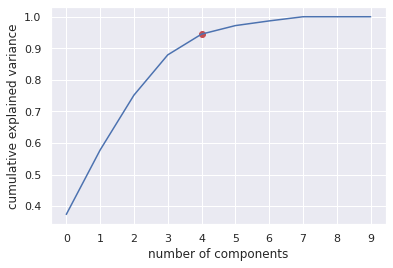

In [28]:
# Plotting the cumulative explained variance by the number of components

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.xticks(range(10))
plt.scatter(4, np.cumsum(pca.explained_variance_ratio_)[4], color='r')
plt.show()

In [29]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(encoded_df)

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [30]:
print(f"The 4 components account for {round(np.sum(pca.explained_variance_ratio_), 1)*100}% variance")

The 4 components account for 90.0% variance


In [31]:
# PCA with only 2 components to be able to plot it

pca = PCA(n_components=2)
pca.fit(encoded_df)
x_pca = pca.fit_transform(encoded_df)

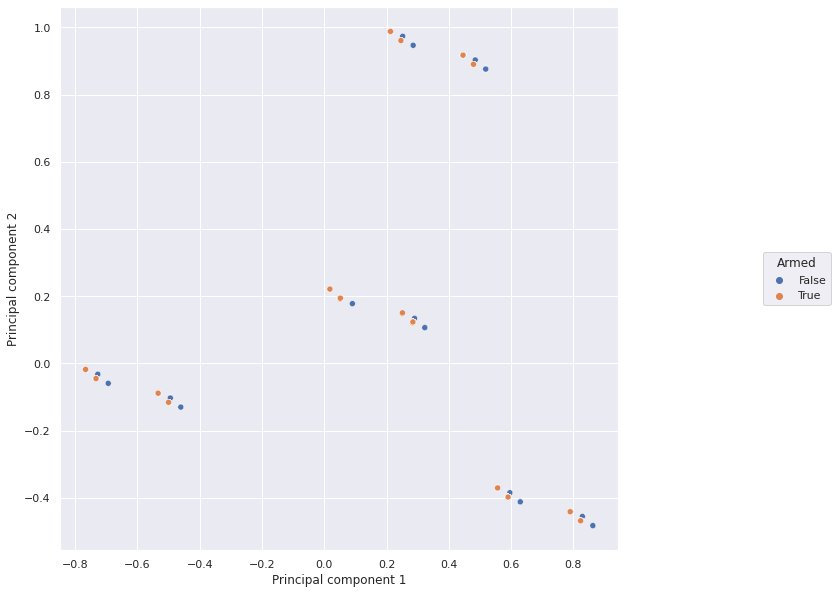

In [32]:
plt.figure(figsize=(10, 10))
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2');
sns.scatterplot(x = x_pca[:, 0], y = x_pca[:, 1], hue=clean_df.armed).legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

As we can see, there are four clusters of data

### t-SNE

In [33]:
# Performing t-SNE on the same encoded values and visualising the result

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(encoded_df)

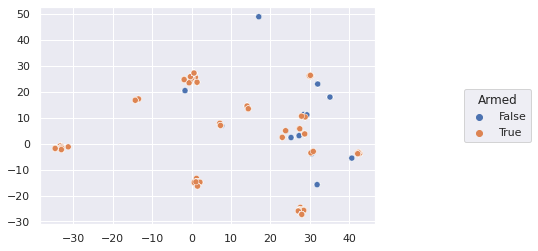

In [34]:
sns.scatterplot(x = tsne[:, 0], y = tsne[:, 1], hue=clean_df.armed).legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, title='Armed')

## Cluster analysis

In [35]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   index                    1986 non-null   int64         
 1   name                     1986 non-null   object        
 2   date                     1986 non-null   datetime64[ns]
 3   manner_of_death          1986 non-null   object        
 4   armed                    1986 non-null   bool          
 5   age                      1986 non-null   float64       
 6   gender                   1986 non-null   object        
 7   race                     1986 non-null   object        
 8   city                     1986 non-null   object        
 9   state                    1986 non-null   object        
 10  signs_of_mental_illness  1986 non-null   bool          
 11  threat_level             1986 non-null   object        
 12  flee                     1986 non-

In [36]:
# Encoding string data to numeric for clustering

X = pd.get_dummies(clean_df.filter(['manner_of_death', 'signs_of_mental_illness', 'armed', 'race', 'flee', 'gender']))
X.head()

,signs_of_mental_illness,armed,manner_of_death_shot,manner_of_death_shot and Tasered,race_A,race_B,race_H,race_N,race_O,race_W,flee_Car,flee_Foot,flee_Not fleeing,flee_Other,gender_F,gender_M
0,True,True,1,0,1,0,0,0,0,0,0,0,1,0,0,1
1,False,True,1,0,0,0,0,0,0,1,0,0,1,0,0,1
2,False,False,0,1,0,0,1,0,0,0,0,0,1,0,0,1
3,True,True,1,0,0,0,0,0,0,1,0,0,1,0,0,1
4,False,True,1,0,0,0,1,0,0,0,0,0,1,0,0,1


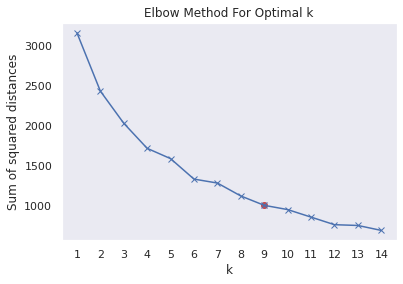

In [37]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)


# Plotting the sum of square distances by k to find optimal k

plt.grid()
plt.xticks(range(15))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.scatter(9, Sum_of_squared_distances[8], color='r')
plt.show()

In [38]:
# Performing k-means clustering with the optimal k of 9

from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=9)
clusters = kmeans.fit_predict(X)
clusters

array([6, 2, 0, ..., 2, 4, 3], dtype=int32)

In [39]:
# Making the clusters understandable by converting cluster id to the index in the original dataframe

similar_shootings = []

for num in range(np.max(clusters)+1):
  similar_shootings.append(np.squeeze(np.where(clusters == num)))

similar_shootings[0][:10]

array([  2,  10,  23,  38,  43,  51,  68,  74,  99, 111])

In [40]:
# Picking and displaying a random cluster of similar shootings

import random

sample = similar_shootings[random.randint(0, np.size(similar_shootings)-1)]

random_similar = pd.DataFrame()

for id in sample:
  random_similar[id] = clean_df.iloc[id]

random_similar.transpose().reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,index,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera
0,45,Dewayne Carr,2015-01-20,shot,True,42,M,B,Scottsdale,AZ,False,other,Car,False
1,50,Tiano Meton,2015-01-22,shot,True,25,M,B,Sierra Blanca,TX,False,attack,Car,False
2,80,Yuvette Henderson,2015-02-03,shot,True,38,F,B,Emeryville,CA,False,attack,Car,False
3,87,Jimmy Ray Robinson Jr.,2015-02-04,shot,True,51,M,B,Lorena,TX,False,attack,Car,False
4,138,Glenn Lewis,2015-02-25,shot,True,27,M,B,Oklahoma City,OK,False,other,Car,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,2045,Tavis Crane,2017-02-01,shot,True,23,M,B,Arlington,TX,False,attack,Car,False
77,2046,Michael Russo,2017-02-01,shot,True,31,M,B,Highland,CA,False,attack,Car,False
78,2049,Jamake Cason Thomas,2017-02-03,shot,True,22,M,B,Rowland,NC,False,attack,Car,False
79,2053,Jamake Cason Thomas,2017-02-03,shot,True,22,M,B,Rowland,NC,False,attack,Car,False


## Building a model and predicting new values

In [41]:
# Separating and encoding data to integers

from sklearn.preprocessing import LabelEncoder

y = LabelEncoder().fit_transform(clean_df['race'])
X = pd.get_dummies(clean_df.filter(['manner_of_death', 'signs_of_mental_illness',
                                    'armed', 'flee', 'threat_level', 'state', 'gender', 
                                    'age', 'city']))

In [42]:
# Splitting the dataset

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
train_test_split(X, y, test_size=0.3)


# Building a random forests classifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)


print(f"Model predicts with {round((rfc.score(X_test, y_test)*100), 2)}% accuracy")

Model predicts with 59.9% accuracy


In [43]:
# Testing for accuracy with a random sample

random_id = random.randint(0, np.size(y)-1)

new_prediction = rfc.predict([X.iloc[random_id]])
print(f"The model predicted the race to be {new_prediction[0]}, while the ground truth is {y[random_id]} ({clean_df['race'].iloc[random_id]})")

The model predicted the race to be 5, while the ground truth is 5 (W)
